In [ ]:
!pip install qiskit

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!pip install qiskit-finance

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
#importing the required stuff
from qiskit import Aer
from qiskit.algorithms import VQE, QAOA, NumPyMinimumEigensolver
from qiskit.algorithms.optimizers import COBYLA
from qiskit.circuit.library import TwoLocal
from qiskit.utils import QuantumInstance
from qiskit_finance.applications.optimization import PortfolioOptimization
from qiskit_finance.data_providers import *
from qiskit_finance import QiskitFinanceError
from qiskit_optimization.algorithms import MinimumEigenOptimizer
from qiskit_optimization.applications import OptimizationApplication
from qiskit_optimization.converters import QuadraticProgramToQubo
import numpy as np
import matplotlib.pyplot as plt

import datetime
import pandas as pd
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
import csv
import yfinance as yf
import pandas_datareader.data as web
from qiskit_finance.applications.optimization import PortfolioDiversification

In [ ]:
%matplotlib inline

In [ ]:
# set number of assets (= number of qubits)

seed = 123

assets = ["JPM", "GS", "MSFT", "AAPL", "WMT", "MCD"]


# Using data from yahoo finance
# use the name listed for particular company that you wish to add

data = YahooDataProvider(
        tickers= assets , 
        start=datetime.datetime(2011, 1, 1),
        end=datetime.datetime(2015, 12, 31),
    )

num_assets = len(assets)
data.run()

mu = data.get_period_return_mean_vector()
sigma = data.get_period_return_covariance_matrix()
rho = data.get_similarity_matrix()
# print(rho)

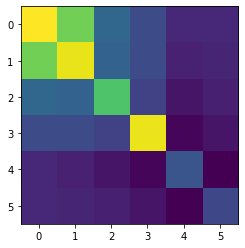

In [ ]:
# plot sigma
plt.imshow(sigma, interpolation="nearest")
plt.show()

In [ ]:
q = 0.5  # set risk factor
budget = num_assets // 2  # set budget
penalty = num_assets  # set parameter to scale the budget penalty term


portfolio = PortfolioOptimization(
    expected_returns=mu, covariances=sigma, risk_factor=q, budget=budget,
)
qp = portfolio.to_quadratic_program()
qp

<QuadraticProgram: minimize 0.00014417217949472844*x_0^2 + 0.00023453207724128..., 6 variables, 1 constraints, 'Portfolio optimization'>

In [ ]:
def index_to_selection(i, num_assets):
    s = "{0:b}".format(i).rjust(num_assets)
    x = np.array([1 if s[i] == "1" else 0 for i in reversed(range(num_assets))])
    return x


def print_result(result,fname):
    
    f = open(fname, 'w')
    header = ['SELECTION', 'VALUE', 'PROBABLITY']
    writer = csv.writer(f)
    writer.writerow(header)
    
    selection = result.x
    value = result.fval
    print("Optimal: selection {}, value {:.4f}".format(selection, value))

    eigenstate = result.min_eigen_solver_result.eigenstate
    eigenvector = eigenstate if isinstance(eigenstate, np.ndarray) else eigenstate.to_matrix()
    probabilities = np.abs(eigenvector) ** 2
    i_sorted = reversed(np.argsort(probabilities))
    print("\n----------------- Full result ---------------------")
    print("selection\tvalue\t\tprobability")
    print("---------------------------------------------------")
    for i in i_sorted:
        x = index_to_selection(i, num_assets)
        value = QuadraticProgramToQubo().convert(qp).objective.evaluate(x)
        # value = portfolio.to_quadratic_program().objective.evaluate(x)
        probability = probabilities[i]
        row = [x, value, probability]
        writer.writerow(row)
        print("%10s\t%.4f\t\t%.4f" % (x, value, probability))
    f.close()

In [ ]:
#classical reference solution
#provide fname ='complete address/location of your .csv file'

exact_mes = NumPyMinimumEigensolver()
exact_eigensolver = MinimumEigenOptimizer(exact_mes)

result = exact_eigensolver.solve(qp)
fname = 'nes1.csv' #change the location and nsame of .csv file

print_result(result,fname)

Optimal: selection [0. 0. 1. 1. 0. 1.], value -0.0017

----------------- Full result ---------------------
selection	value		probability
---------------------------------------------------
[0 0 1 1 0 1]	-0.0017		1.0000
[1 1 1 1 1 1]	9.0445		0.0000
[0 1 1 1 1 0]	1.0039		0.0000
[0 0 1 1 1 0]	-0.0014		0.0000
[1 1 0 1 1 0]	1.0042		0.0000
[0 1 0 1 1 0]	-0.0008		0.0000
[1 0 0 1 1 0]	-0.0012		0.0000
[0 0 0 1 1 0]	1.0042		0.0000
[1 1 1 0 1 0]	1.0043		0.0000
[0 1 1 0 1 0]	-0.0007		0.0000
[1 0 1 0 1 0]	-0.0011		0.0000
[0 0 1 0 1 0]	1.0043		0.0000
[1 1 0 0 1 0]	-0.0004		0.0000
[0 1 0 0 1 0]	1.0049		0.0000
[1 0 0 0 1 0]	1.0045		0.0000
[0 0 0 0 1 0]	4.0202		0.0000
[1 1 1 1 0 0]	1.0039		0.0000
[0 1 1 1 0 0]	-0.0012		0.0000
[1 0 1 1 0 0]	-0.0015		0.0000
[0 0 1 1 0 0]	1.0038		0.0000
[1 1 0 1 0 0]	-0.0008		0.0000
[0 1 0 1 0 0]	1.0044		0.0000
[1 0 0 1 0 0]	1.0040		0.0000
[0 0 0 1 0 0]	4.0197		0.0000
[1 1 1 0 0 0]	-0.0007		0.0000
[0 1 1 0 0 0]	1.0044		0.0000
[1 0 1 0 0 0]	1.0041		0.0000
[0 0 1 0 0 0]	4.01

### [0. 0. 1. 1. 0. 1.] is the solution by Exact solver and QAOA. but for VQE it's the most probable bit string, but it doesn't gives lowest energy to this bitstring, that's why it doesn't be the optimal solution with VQE. 

In [ ]:
!pip install qiskit-aer

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# VQE solution
#provide fname ='complete address/location of your .csv file'

from qiskit.utils import algorithm_globals

algorithm_globals.random_seed = 1234
backend = Aer.get_backend("statevector_simulator")

cobyla = COBYLA()
cobyla.set_options(maxiter=500)
ry = TwoLocal(num_assets, "ry", "cz", reps=3, entanglement="full")
quantum_instance = QuantumInstance(backend=backend, shots=8192, seed_simulator=seed, seed_transpiler=seed)
vqe_mes = VQE(ry, optimizer=cobyla, quantum_instance=quantum_instance)
vqe = MinimumEigenOptimizer(vqe_mes)
result = vqe.solve(qp)

fname = 'vqe1.csv' #change the location and name of .csv file
print_result(result, fname)
# print(result)

#[0. 0. 1. 1. 0. 1.] --numpy exact solver

Optimal: selection [1. 0. 1. 0. 0. 1.], value -0.0013

----------------- Full result ---------------------
selection	value		probability
---------------------------------------------------
[0 0 1 0 1 1]	-0.0012		0.7054
[1 0 0 0 1 1]	-0.0010		0.1483
[1 1 1 0 0 0]	-0.0007		0.1063
[1 0 1 0 1 0]	-0.0011		0.0223
[1 1 0 0 0 1]	-0.0007		0.0111
[0 1 1 0 0 1]	-0.0010		0.0064
[0 1 1 1 0 0]	-0.0012		0.0000
[1 1 0 1 0 0]	-0.0008		0.0000
[1 0 1 0 0 1]	-0.0013		0.0000
[0 0 0 0 1 0]	4.0202		0.0000
[1 1 1 0 1 0]	1.0043		0.0000
[1 0 1 0 1 1]	1.0037		0.0000
[1 0 0 0 1 0]	1.0045		0.0000
[1 1 0 0 1 0]	-0.0004		0.0000
[0 0 1 0 1 0]	1.0043		0.0000
[1 0 0 0 0 1]	1.0042		0.0000
[1 1 1 1 0 0]	1.0039		0.0000
[1 1 0 0 1 1]	1.0044		0.0000
[0 1 0 0 1 0]	1.0049		0.0000
[0 1 1 0 1 0]	-0.0007		0.0000
[0 0 0 0 0 1]	4.0199		0.0000
[1 1 1 0 1 1]	4.0194		0.0000
[0 0 0 0 1 1]	1.0044		0.0000
[1 1 0 1 0 1]	1.0040		0.0000
[1 1 0 0 0 0]	1.0048		0.0000
[1 1 1 0 0 1]	1.0041		0.0000
[1 0 0 1 1 1]	1.0036		0.0000
[1 0 1 0 0 0]	1.00

In [ ]:
# QAOA solution
#provide fname ='complete address/location of your .csv file'

algorithm_globals.random_seed = 1234
backend = Aer.get_backend("statevector_simulator")

cobyla = COBYLA()
cobyla.set_options(maxiter=250)
quantum_instance = QuantumInstance(backend=backend, shots=8192, seed_simulator=seed, seed_transpiler=seed)
qaoa_mes = QAOA(optimizer=cobyla, reps=3, quantum_instance=quantum_instance)
qaoa = MinimumEigenOptimizer(qaoa_mes)
result = qaoa.solve(qp)

fname = 'qaoa1.csv' #change the location and name of .csv file
print_result(result, fname)

# [0. 0. 1. 1. 0. 1.] -numpy exact solver

Optimal: selection [0. 0. 1. 1. 0. 1.], value -0.0017

----------------- Full result ---------------------
selection	value		probability
---------------------------------------------------
[0 0 1 1 0 1]	-0.0017		0.0473
[1 0 1 1 0 0]	-0.0015		0.0473
[1 0 0 1 0 1]	-0.0014		0.0473
[0 0 1 1 1 0]	-0.0014		0.0473
[1 0 1 0 0 1]	-0.0013		0.0473
[0 0 0 1 1 1]	-0.0013		0.0472
[0 1 1 1 0 0]	-0.0012		0.0472
[0 0 1 0 1 1]	-0.0012		0.0472
[1 0 0 1 1 0]	-0.0012		0.0472
[0 1 0 1 0 1]	-0.0011		0.0472
[1 0 1 0 1 0]	-0.0011		0.0472
[0 1 1 0 0 1]	-0.0010		0.0472
[1 0 0 0 1 1]	-0.0010		0.0472
[0 1 0 1 1 0]	-0.0008		0.0472
[1 1 0 1 0 0]	-0.0008		0.0472
[0 1 1 0 1 0]	-0.0007		0.0472
[1 1 1 0 0 0]	-0.0007		0.0472
[1 1 0 0 0 1]	-0.0007		0.0472
[0 1 0 0 1 1]	-0.0006		0.0472
[1 1 0 0 1 0]	-0.0004		0.0471
[1 0 1 1 0 1]	1.0033		0.0017
[0 0 1 1 1 1]	1.0034		0.0017
[1 0 1 1 1 0]	1.0035		0.0017
[1 0 0 1 1 1]	1.0036		0.0017
[0 1 1 1 0 1]	1.0036		0.0017
[1 0 1 0 1 1]	1.0037		0.0017
[0 1 1 1 1 0]	1.0039		0.0017
[0 1 0 1 

#### weight allocation part after asset selection using quantum

In [ ]:
selected_assets = [0, 0, 1, 1, 0, 1]
assets = ["JPM", "GS", "MSFT", "AAPL", "WMT", "MCD"]

selected_bitstring = [i for i, e in enumerate(selected_assets) if e == 1]
# print(selected_bitstring)
my_assets = [assets[i] for i in selected_bitstring]
print("your lucky assets are ",my_assets)

your lucky assets are  ['MSFT', 'AAPL', 'MCD']


In [ ]:
import yfinance as yf
import numpy as np
selected_stocks_data = yf.download(my_assets, start = '2011-1-1', end = '2015-12-31')['Adj Close']
selected_stocks_data.head()

[*********************100%***********************]  3 of 3 completed


,AAPL,MCD,MSFT
Date,,,
2011-01-03,10.049907,55.079639,21.917929
2011-01-04,10.102355,53.432976,22.004099
2011-01-05,10.184994,53.684654,21.933592
2011-01-06,10.176760,53.361073,22.575930
2011-01-07,10.249640,53.476139,22.403606


In [ ]:
log_return = np.log(selected_stocks_data/selected_stocks_data.shift(1))
log_return.head()

,AAPL,MCD,MSFT
Date,,,
2011-01-03,NaN,NaN,NaN
2011-01-04,0.005205,-0.030352,0.003924
2011-01-05,0.008147,0.004699,-0.003209
2011-01-06,-0.000809,-0.006046,0.028865
2011-01-07,0.007136,0.002154,-0.007662


In [ ]:
import numpy as np
weights = np.array(np.random.random(len(my_assets)))

print('normalised weights :')
weights = weights/np.sum(weights)
print(weights)

normalised weights :
[0.29363893 0.32216275 0.38419832]


In [ ]:
from scipy.optimize import minimize

def get_ret_vol_sr(weights): 
    weights = np.array(weights)
    ret = np.sum(log_return.mean() * weights) * 252
    vol = np.sqrt(np.dot(weights.T,np.dot(log_return.cov()*252,weights)))
    sr = ret/vol 
    return np.array(sr)
    

# minimize negative Sharpe Ratio
def neg_sharpe(weights): 
    return get_ret_vol_sr(weights)*-1

# check allocation sums to 1
def check_sum(weights): 
    return np.sum(weights) - 1

In [ ]:
# create constraint variable
cons = ({'type':'eq','fun':check_sum})

In [ ]:
# create weight boundaries
bounds = tuple((0, 1) for stocks in range(len(my_assets)))

In [ ]:
# initial guess
# init_guess = [0.1 for stocks in range(len(my_assets))]
init_guess = [0.3, 0.5, 0.2]
# tuple((0, 1) for stocks in range(len(my_assets)))

In [ ]:
neg_sharpe(weights)

-0.9417878089731659

In [ ]:
# from scipy.optimize import minimize
opt_results = minimize(neg_sharpe, init_guess, method='SLSQP', bounds=bounds, constraints=cons)
opt_results

     fun: -0.9709165455564556
     jac: array([ 0.00035339, -0.00021135,  0.00015353])
 message: 'Optimization terminated successfully'
    nfev: 16
     nit: 4
    njev: 4
  status: 0
 success: True
       x: array([0.21889293, 0.54065665, 0.24045042])

In [ ]:
my_weights = np.array(opt_results.x)
my_weights = my_weights.tolist()

In [ ]:
tot_weights = np.sum(my_weights)
tot_weights

1.0

In [ ]:
weights_alloc = dict(zip(my_assets, my_weights))
weights_alloc

{'MSFT': 0.21889292733922133,
 'AAPL': 0.5406566501921577,
 'MCD': 0.24045042246862097}

In [ ]:
my_assets

['MSFT', 'AAPL', 'MCD']

In [ ]:
ret = np.sum(log_return.mean() * my_weights) * 252 # returns of a portfolio after optimum weight allocation
vol = np.sqrt(np.dot(weights.T,np.dot(log_return.cov()*252,my_weights))) # risk of a portfolio after optimum weight allocation
sharpe_ratio = ret/vol # sharpe ratio of a portfolio after optimum weight allocation
print("sharpe ratio of your porrtfolio after optimization is ", sharpe_ratio)

risk_ret_dict_of_quantum = {
    'returns' : ret*100,
    'risk' : vol*100, 
    'sharpe_ratio' : sharpe_ratio 
}

sharpe ratio of your porrtfolio after optimization is  0.9360188993315305


In [ ]:
risk_ret_dict_of_quantum

{'returns': 14.538798753904938,
 'risk': 15.532591023843645,
 'sharpe_ratio': 0.9360188993315305}

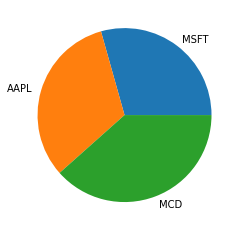

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

y = np.array(weights)
mylabels = my_assets

plt.pie(y, labels = mylabels)
plt.show()

In [ ]:
# 4_stocks= ["JPM", "GS", "MSFT", "WMT"]
# 6_stocks= ["JPM", "GS", "MSFT", "AAPL", "WMT", "MCD"]
# 8_stocks= ["JPM", "GS", "MSFT", "AAPL", "KO", "WMT", "MCD", "NKE"]
# 10_stocks=["JPM", "GS", "MSFT", "AAPL", "KO", "WMT", "DIS", "BA", "MCD", "NKE"]

## MPT CODE to benchmark 

In [ ]:
import numpy as np
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import scipy.optimize as optimization

In [ ]:
NUM_TRADING_DAYS = 252 #252*5 cosnidered previously, now I'm just taing for 1 year
NUM_PORTFOLIOS = 10000
stocks = ["JPM", "GS", "MSFT", "AAPL", "WMT", "MCD"]

In [ ]:
start_date = '2011-01-01' # YY/MM/DD
end_date = '2015-12-31'   # YY/MM/DD

In [ ]:
def download_data():
    stock_data = {}
    for stock in stocks:
        ticker = yf.Ticker(stock)
        stock_data[stock] = ticker.history(start=start_date, end=end_date, )['Close']

    return pd.DataFrame(stock_data)

In [ ]:
def show_data(data):
    data.plot(figsize=(8, 5))
    plt.show()

# show_data(data)

In [ ]:
def calculate_return(data):
    log_return = np.log(data / data.shift(1))
    return log_return[1:]

In [ ]:
def show_statistics(returns):
    print(returns.mean() * NUM_TRADING_DAYS)
    print(returns.cov() * NUM_TRADING_DAYS)

In [ ]:
def show_mean_variance(returns, weights):
    portfolio_return = np.sum(returns.mean() * weights) * NUM_TRADING_DAYS
    portfolio_volatility = np.sqrt(np.dot(weights, np.dot(returns.cov() * NUM_TRADING_DAYS, weights)))
    print('Expected portfolio mean: ', portfolio_return)
    print('Expected portfolio volatility: ', portfolio_volatility)
    print("sharpe ratio of a portfolio is ", portfolio_return/portfolio_volatility)

In [ ]:
def show_portfolios(returns, volatilities):
    plt.figure(figsize=(8, 5))
    plt.scatter(volatilities, returns, c=returns / volatilities, marker='o')
    plt.grid(True)
    plt.xlabel('Expected Volatility')
    plt.ylabel('Expected Return')
    plt.colorbar(label='Sharpe Ratio')
    plt.show()

In [ ]:
def generate_portfolios(returns):
    portfolio_means = []
    portfolio_risks = []
    portfolio_weights = []

In [ ]:
def generate_portfolios(returns):
    portfolio_means = []
    portfolio_risks = []
    portfolio_weights = []

    for _ in range(NUM_PORTFOLIOS):
        w = np.random.random(len(stocks))
        w /= np.sum(w)
        portfolio_weights.append(w)
        portfolio_means.append(np.sum(returns.mean() * w) * NUM_TRADING_DAYS)
        portfolio_risks.append(np.sqrt(np.dot(w.T, np.dot(returns.cov() * NUM_TRADING_DAYS, w))))

    return np.array(portfolio_weights), np.array(portfolio_means), np.array(portfolio_risks)

In [ ]:
def statistics(weights, returns):
    portfolio_return = np.sum(returns.mean() * weights) * NUM_TRADING_DAYS
    portfolio_volatility = np.sqrt(np.dot(weights.T, np.dot(returns.cov() * NUM_TRADING_DAYS, weights)))

    return np.array([portfolio_return, portfolio_volatility, portfolio_return / portfolio_volatility])

In [ ]:
def min_function_sharpe(weights, returns):
    return -statistics(weights, returns)[2]

In [ ]:
def optimize_portfolio(weights, returns):
    constraints = {'type': 'eq', 'fun': lambda x: np.sum(x) - 1}
    bounds = tuple((0, 1) for _ in range(len(stocks)))
    return optimization.minimize(fun=min_function_sharpe, x0=weights[0], args=returns, method='SLSQP',
                                 bounds=bounds, constraints=constraints)


In [ ]:
def print_optimal_portfolio(optimum, returns):
    print('Optimal Portfolio: ', optimum['x'].round(3))
    print('Expected return, volatility and sharpe ratio: ', statistics(optimum['x'].round(3), returns))


In [ ]:
def show_optimal_portfolio(opt, rets, portfolio_rets, portfolio_vols):
    plt.figure(figsize=(8, 5))
    plt.scatter(portfolio_vols, portfolio_rets, c=portfolio_rets / portfolio_vols, marker='o')
    plt.grid(True)
    plt.xlabel('Expected Volatility')
    plt.ylabel('Expected Return')
    plt.colorbar(label='Sharpe Ratio')
    plt.plot(statistics(opt['x'], rets)[1], statistics(opt['x'], rets)[0], 'g*', markersize=20.0)
    plt.show()


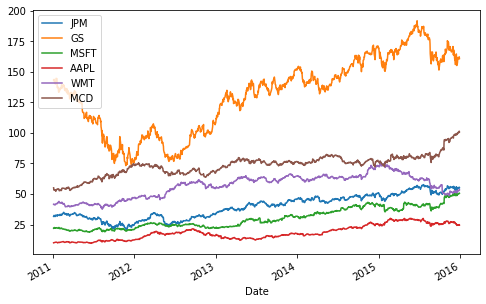

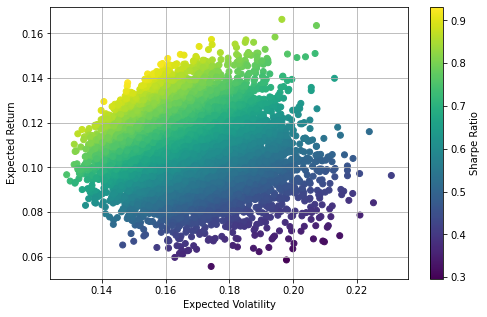

Optimal Portfolio:  [0.    0.    0.24  0.219 0.    0.541]
Expected return, volatility and sharpe ratio:  [0.1453733  0.14972785 0.97091694]


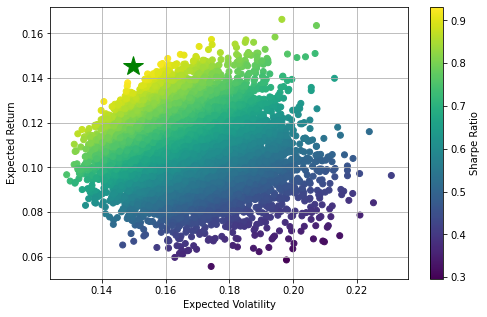

In [ ]:
if __name__ == '__main__':
    # print(download_data())
    dataset = download_data()
    show_data(dataset)
    log_daily_returns = calculate_return(dataset)
    # show_statistics(log_daily_returns)
    # show_mean_variance(log_daily_returns, [0.1, 0.2, 0.3, 0.2, 0.1, 0.1])
    pweights, means, risks = generate_portfolios(log_daily_returns)
    show_portfolios(means, risks)
    optimum = optimize_portfolio(pweights, log_daily_returns)
    print_optimal_portfolio(optimum, log_daily_returns)
    show_optimal_portfolio(optimum, log_daily_returns, means, risks)

In [ ]:
risk_ret_dict_of_quantum

{'returns': 14.538798753904938,
 'risk': 15.532591023843645,
 'sharpe_ratio': 0.9360188993315305}